# Conformal Prediction - Basic Testing for state action conditioning

Given an expected dataset from a state action-conditioned world model, how will conformal prediction behave?

In [ ]:
import numpy as np
from collections import deque

# consider the wm has correctly learned a 30% slip rate transition for a particular state
# state 3,1 - action right
wm = np.zeros(shape=(16,))
wm[4] = 0.14
wm[12] = 0.16
wm[9] = 0.5
# wm[3] = 0.2
# wm[1] = 0.01

wm = wm / wm.sum()

n = 200
alpha = 0.2
# noise_amp = 1e-8
noise_amp = 0
seed = 42

# so here are our world model preds. Let's conformalise now :)
def run_experiment(exp_seed: int, alpha: float, noise_amp: float):
    rng = np.random.default_rng(exp_seed)

    # sample a calibration set
    calib_set = deque(maxlen=n)
    for _ in range(n):
        calib_set.append(rng.choice(range(16), p=wm))

    # now we need to conformalise.
    scores = [1 - wm[i] + noise_amp * rng.random() for i in calib_set]
    q_level = min(1.0, np.ceil((n+1)*(1-alpha))/n)
    qhat = np.quantile(scores, q_level, method='higher')
    prediction_set = np.flatnonzero(wm >= (1 - qhat))

    true_coverage_rate = wm[prediction_set.tolist()].sum()
    return true_coverage_rate

In [65]:
n_runs = 50
n_alphas = 100
alphas = np.linspace(0, 1, n_alphas)

coverages_no_noise = np.zeros((n_alphas, n_runs))
coverages_w_noise = np.zeros((n_alphas, n_runs))
for alpha_ix, alpha in enumerate(alphas):
    for run_seed in range(50):
        coverages_no_noise[alpha_ix, run_seed] = run_experiment(run_seed, alpha, noise_amp=0.0)
        coverages_w_noise[alpha_ix, run_seed] = run_experiment(run_seed, alpha, noise_amp=1e-8)

coverages_no_noise = coverages_no_noise.mean(axis=1)
coverages_w_noise = coverages_w_noise.mean(axis=1)

# Empirical Coverage

Uh oh - for small $\alpha$, our coverage guarantee is completely violated: We're undercovering heavily, for the most typical values of $\alpha$ we'd like to use. Not good!

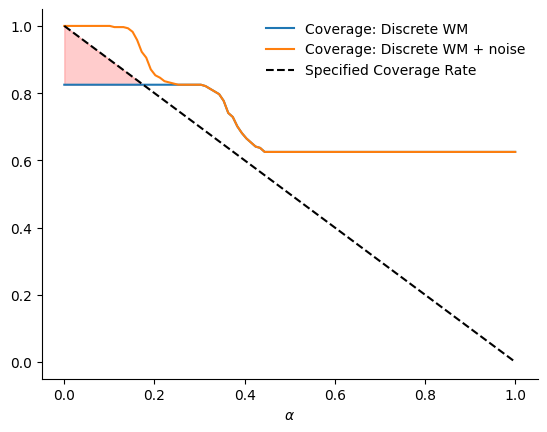

In [ ]:
import matplotlib.pyplot as plt
from crl.utils.graphing import despine

plt.plot(alphas, coverages_no_noise, label='Coverage: Discrete WM')
plt.plot(alphas, coverages_w_noise, label='Coverage: Discrete WM + noise')
plt.plot(alphas, 1 - alphas, label='Specified Coverage Rate', linestyle='--', c='k')

start = -1
end = -1
flagged = False
for ix, alpha in enumerate(alphas):
    if (1 - alpha < coverages_no_noise[ix]) and flagged:
        end = ix
        break
    elif 1 - alpha > coverages_no_noise[ix] and not flagged:
        start = ix
        flagged = True

plt.fill_between(alphas[start:end], coverages_no_noise[start:end], 1 - alphas[start:end], color='red', alpha=0.2)
plt.xlabel(r'$\alpha$')
despine(plt.gca())
plt.legend(frameon=False);

## What's going on?

It's a floating point error... First let's plot the histogram of scores to recall exactly what the quantile calculation in CP is doing. On the left we plot the histogram of scores with no noise. The fact that we don't see a little sliver at s=0.825 is the first hint something is wrong.

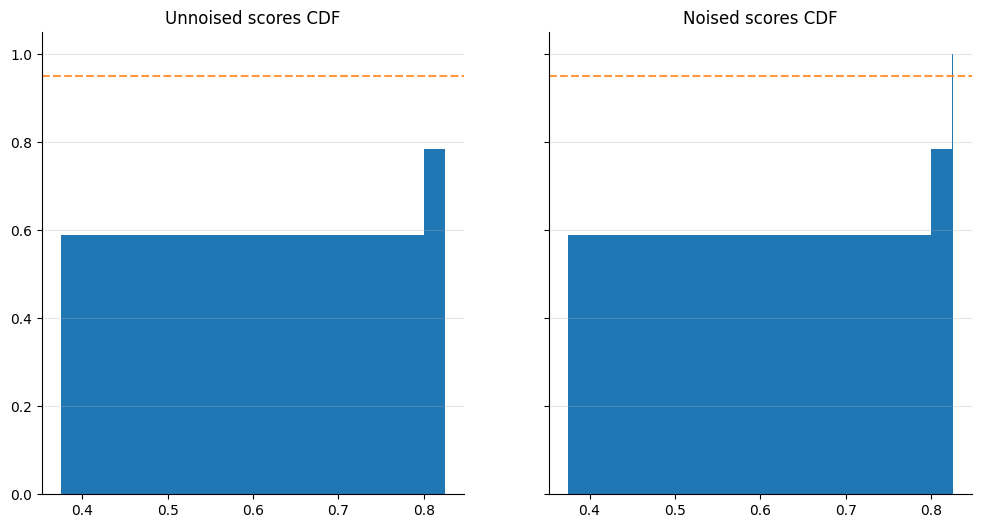

In [ ]:
rng = np.random.default_rng(12)

wm = np.zeros(shape=(16,))
wm[4] = 0.14
wm[12] = 0.16
wm[9] = 0.5
wm = wm / wm.sum()

calib_set_no_noise = deque(maxlen=n)
calib_set_w_noise = deque(maxlen=n)
for _ in range(n):
    choice = rng.choice(range(16), p=wm)
    score = 1 - wm[choice]
    calib_set_no_noise.append(score)
    calib_set_w_noise.append(score + 1e-8 * rng.random())

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(12, 6))

axes[0].hist(calib_set_no_noise, density=True, cumulative=True, bins=1000)
axes[1].hist(calib_set_w_noise, density=True, cumulative=True, bins=1000)

[despine(ax) for ax in axes]
axes[0].grid(which='major', axis='y',alpha=0.3)
axes[1].grid(which='major', axis='y',alpha=0.3)

axes[0].set_title('Unnoised scores CDF')
axes[1].set_title('Noised scores CDF')
axes[0].axhline(0.95, c='tab:orange', alpha=0.8, linestyle='--')
axes[1].axhline(0.95, c='tab:orange', alpha=0.8, linestyle='--')

plt.show()

In [ ]:
# The rightmost bin for the unnoised one is exactly 0.825. What could go wrong?
bin_vals_no_noise, bins_no_noise, _ = plt.hist(calib_set_no_noise, density=True, cumulative=True, bins=1000);
bin_vals_w_noise, bins_w_noise, _ = plt.hist(calib_set_w_noise, density=True, cumulative=True, bins=1000);
plt.close()
print(f'Bins: No Noise{bins_no_noise[-5:]}')
print(f'Bins: W/ Noise{bins_w_noise[-5:]}')

Bins: No Noise[0.8232  0.82365 0.8241  0.82455 0.825  ]
Bins: W/ Noise[0.82320001 0.82365001 0.82410001 0.82455001 0.82500001]


In [ ]:
q_level = 0.95
qhat_no_noise = np.quantile(calib_set_no_noise, q=q_level, method='higher')
qhat_w_noise = np.quantile(calib_set_w_noise, q=q_level, method='higher')

print("Exact q_hat for 95% coverage:")
print(f"  No Noise: {qhat_no_noise}")
print(f"  W/ Noise: {qhat_w_noise}")

print("Threshold, 1-q_hat:")
print(f"  No Noise: {1 - qhat_no_noise}")
print(f"  W/ Noise: {1 - qhat_w_noise}")

print("Result of the comparison, 0.175 >= 1 - q_hat:")
print(f"  No Noise: {0.175 >= 1 - qhat_no_noise}")
print(f"  W/ Noise: {0.175 >= 1 - qhat_w_noise}")

Exact q_hat for 95% coverage:
  No Noise: 0.825
  W/ Noise: 0.8250000082485792
Threshold, 1-q_hat:
  No Noise: 0.17500000000000004
  W/ Noise: 0.17499999175142078
Result of the comparison, 0.175 >= 1 - q_hat:
  No Noise: False
  W/ Noise: True


So the problem is floating point error. We can fix by noising, or by adding a tiny positive offset to the scores